# ITCS 4156 - Programming Assignment 4 -  Deep Learning

<font color="blue"> James Cowell - 801101165 </font>

**Note**: Doing *restart and run all* will execute all cells in this notebook without an error and should give you a minimum score of **20/50** by default.

# Instructions

## Overview

- The objective of this programming assignment is to learn how to build neural network models using Tensorflow Keras library. We will perform classification on Fashion MNIST dataset and do analysis of performance by exploring different hyperparameters.


- This assignment has two parts:
    1. Building Keras Models
    2. Hyperparameter Exploration
    
We will go into more details about each part as we proceed.

- Assignment Files:

    - KerasModel.py 
    - train.py
    - evaluate.py

- Some Tips
 - This notebook has a total **9 TODOs**.  
 - If you are feeling overwhelmed by the size of the notebook, try not to as most of it is boilerplate code to support the exploratory analysis in part-2.
 - There is also no math equations to implement. Instead, our objective is to get familar with high-level keras API for easily building and training machine learning models.


## Important Notes


- You are free to create your own class variables in __init__ method. Additionally, you can also define your own functions inside each class. 

- For analysis, you can use any library you want in the notebook. However matplolib, seaborn etc will be unavailable in the evaluation environment if used in the python files.

- **Epochs (number of iterations of data)**: While training your models locally, you can kepp this number as high as you want. But please keep in mind, that for evaluation your job will have a maximum of **10 minutes** to finish training and prediction for all the three algorithms. So tune this parameter, keeping this information in mind.  

- **Plagiarism Detection**: While we encourage peer discussion for understanding concepts etc, code sharing is strictly prohibited. Therefore, a plagiarism detection software will analyze everyone's code to check for similarities.

In [1]:
# This ensures that whenever you make edits in your code files, your changes will get reflected 
# in this notebook as soon you run the cell which imports the method/class from the said code file.

%load_ext autoreload
%autoreload 2

In [2]:
#imports 

import random
import inspect
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# setting random seed for reproducible results

np.random.seed(25)
random.seed(25)

# Dataset

We will be using a popular dataset known as [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). 

```
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.
```


However for the purpose of this assignment, we have modified the original splits of the dataset so that your model performance can be evaluated fairly. There are three splits: train, val, and test. Training and validation datasets are available for you and test split is hidden for evaluation purpose.

In [4]:
from itcs4156.datasets.FMNISTDataset import FMNISTDataset

In [5]:
(X_tr, Y_tr), (X_val, Y_val) = FMNISTDataset().load()

Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\FMNIST\train.zip

Unzipping: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\FMNIST\train.zip

Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\FMNIST\val.zip

Unzipping: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\FMNIST\val.zip

Loading dataset..
Done!


In [6]:
# Lets checkout the shape of our data

print("Shape of training examples: ", X_tr.shape)
print("Shape of validation examples: ", X_val.shape)
print("Shape of training labels: ", Y_tr.shape)
print("Shape of validation labels: ", Y_val.shape)

Shape of training examples:  (50000, 28, 28)
Shape of validation examples:  (10000, 28, 28)
Shape of training labels:  (50000, 1)
Shape of validation labels:  (10000, 1)


In [7]:
# Lets see the count for each unique class in our training dataset

uniques, counts = np.unique(Y_tr, return_counts=True)
print(np.asarray((uniques, counts)).T)

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]


In [8]:
# Following is the corresponding label name for each class in our dataset

label_dict = {
    0 : "T-shirt/top", 
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress", 
    4 : "Coat",
    5 : "Sandal", 
    6 : "Shirt", 
    7 : "Sneaker", 
    8 : "Bag", 
    9 : "Ankle boot"
}

# Utility Functions

In [9]:
# Lets define our beloved utility function for displaying examples

def display_classes(images, labels, shape=(28,28), num_samples=5, label_dict = None):
    all_labels = np.unique(labels)
    n = len(all_labels) * num_samples
    cols = num_samples
    rows = int(n / cols) if n%cols == 0 else (n//cols + 1)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    plt.axis('off')
    for i, label in enumerate(all_labels):
        indexs = np.where(labels==label)[0]
        selected = np.random.choice(indexs, num_samples, replace=False)
        for j, idx in enumerate(selected):
            img = np.reshape(images[idx], shape)
            axs[i,j].imshow(img, cmap=plt.cm.gray)
            axs[i,j].axis('off')
            if label_dict is not None:
                axs[i,j].set_title(label_dict[label], size=20)

In [10]:
# Here is another function for measuring classification performance

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

def my_classification_report(targets, predictions, label_dict = None):
    print(classification_report(targets, predictions))
    labels = np.unique(targets)
    if label_dict is not None:
        true_labels = [label_dict[label] for label in labels]
    else:
        true_labels = labels
    cm = confusion_matrix(targets, predictions, labels=labels)
    df_cm = pd.DataFrame(cm, index=true_labels, columns = true_labels)
    c = 1.5
    k = len(labels) * c
    plt.figure(figsize=(k+c, k))
    sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    
    plt.show()

In [11]:
# Function for plotting trace

def plot_trace(history):
    N = len(history['loss'])
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    for ax, field in zip(axs, ['loss', 'accuracy']):
        ax.plot(history[field], label = 'train', marker='.')
        ax.plot(history['val_'+ field], label = 'val', marker='.')
        ax.set_ylabel(field, fontsize=12)
        ax.set_xlabel('Epochs', fontsize=12)
        ax.legend()


# Visualize

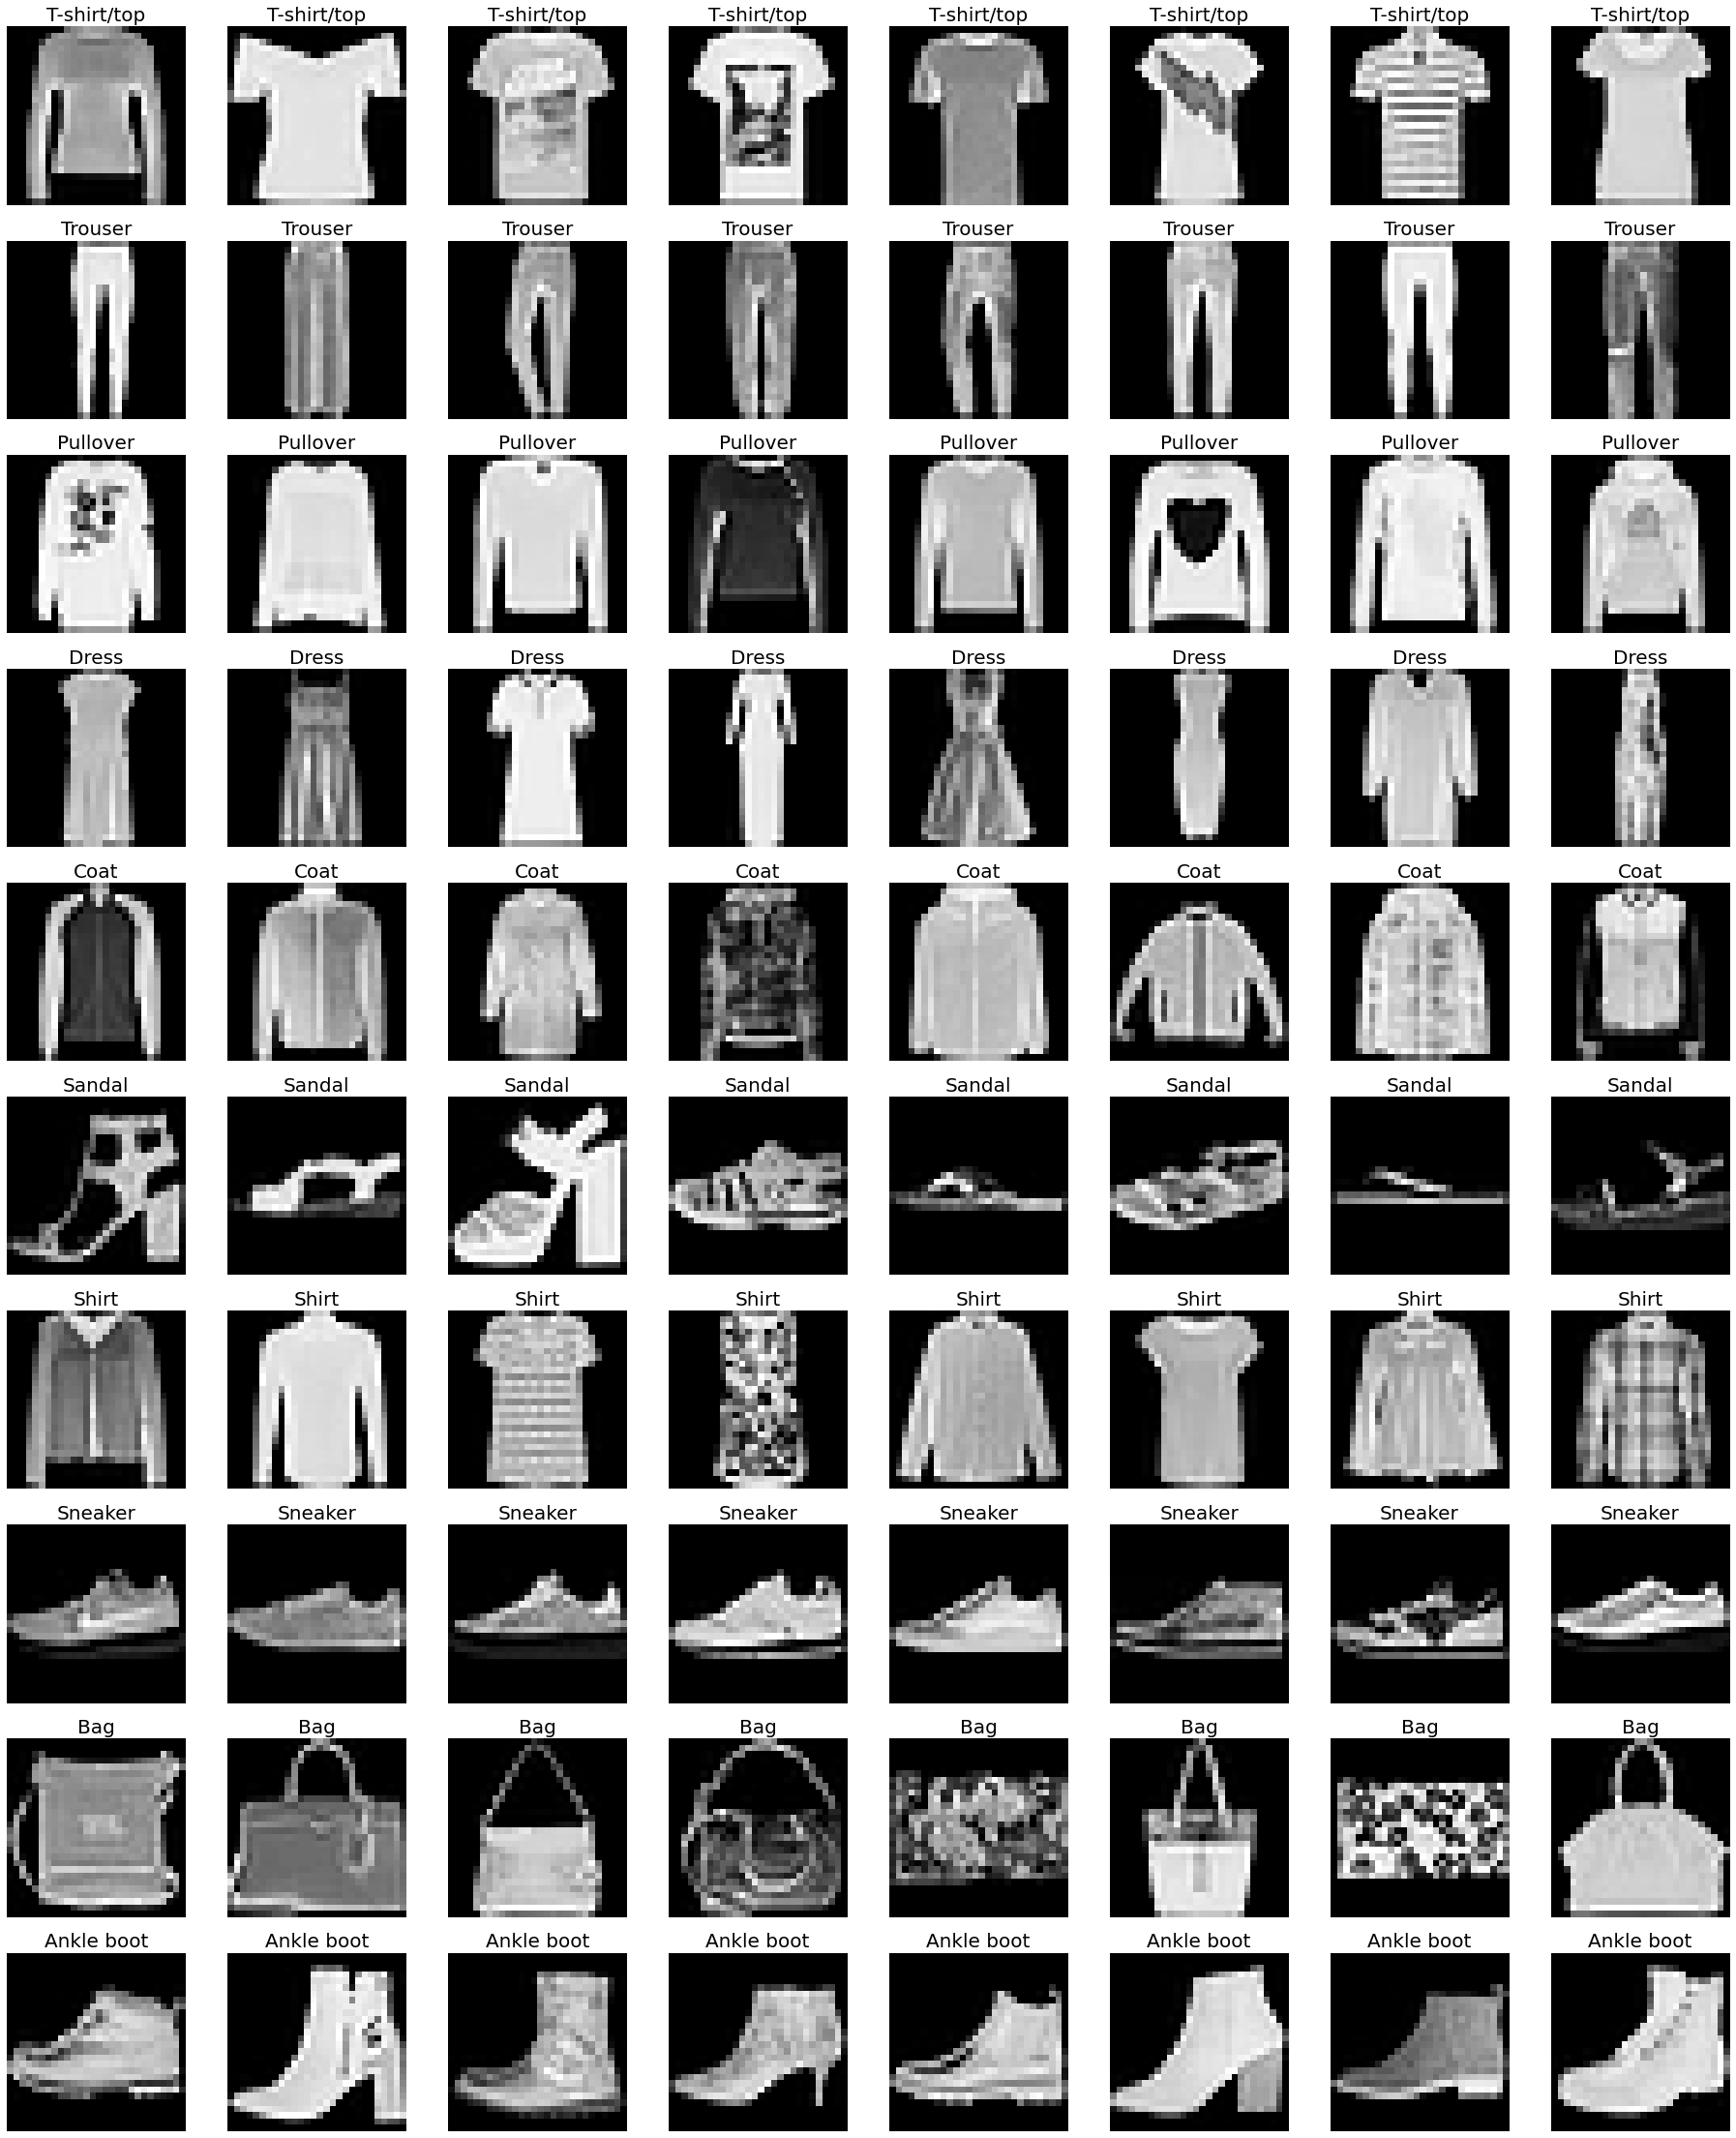

In [12]:
display_classes(X_tr, Y_tr, num_samples=8, label_dict=label_dict)

# 1. Building a Keras Model (50 Pts)

## 1.1 Code

### === TODO - 1 ===

1. Open the **KerasModel.py** file give with this assignment and **carefully** read through all the function documentations.

2. Our objective in this assignemnt is to dynamically build and train a keras model from the parameters given to the __init__ method.

3. You will notice that each parameter takes certain values, mentioned in the documentation. Also each parameter has a default value, when parameter is not specifically set by us, it will take the default value.

4. **Begin by writing code in the functions provided such that the we can atleast build and train a keras model from the default values.**

5. Once we have functioning pipleline (build -> train -> predict), we can go ahead and complete our code such that it works with other parameter values too. We will come to this part in **Exploratory Analysis** section below.


In [13]:
from itcs4156.assignments.DeepLearning.KerasModel import KerasModel

In [14]:
# 1. Initialize Model 

# By default our model should be created with the following parameter values.
# These values are available in the class by default so we don't need to supply them to the KerasModel().

# dense_layers = [20, 10],
# activation = 'relu',
# regularization = None,
# batch_norm = False,
# weight_init = 'glorot_uniform',
# batch_size = 32,
# optimizer = 'adam',
# learning_rate = 0.001,
# epochs = 20

# TODO: Write code in KerasModel.py to support building->training->predicting a keras model using these default values.

my_model = KerasModel()

In [15]:
# 2. Build. Uncomment the line below to see if it is built correctly.

my_model.build().summary()

Model: "default"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                15700     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 16,020
Trainable params: 16,020
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 3. Train
history = my_model.train(X_tr, Y_tr, X_val, Y_val)

Training Model:  default
Epoch 1/20
1563/1563 - 1s - loss: 2.4336 - accuracy: 0.2626 - val_loss: 1.8630 - val_accuracy: 0.3129
Epoch 2/20
1563/1563 - 1s - loss: 1.6879 - accuracy: 0.3806 - val_loss: 1.4813 - val_accuracy: 0.4437
Epoch 3/20
1563/1563 - 1s - loss: 1.4344 - accuracy: 0.4933 - val_loss: 1.6912 - val_accuracy: 0.5074
Epoch 4/20
1563/1563 - 1s - loss: 1.2240 - accuracy: 0.5764 - val_loss: 1.1120 - val_accuracy: 0.6079
Epoch 5/20
1563/1563 - 1s - loss: 1.1474 - accuracy: 0.6031 - val_loss: 1.1843 - val_accuracy: 0.5944
Epoch 6/20
1563/1563 - 1s - loss: 1.1084 - accuracy: 0.6131 - val_loss: 1.1577 - val_accuracy: 0.6023
Epoch 7/20
1563/1563 - 1s - loss: 1.0913 - accuracy: 0.6144 - val_loss: 1.0350 - val_accuracy: 0.6247
Epoch 8/20
1563/1563 - 1s - loss: 1.0311 - accuracy: 0.6207 - val_loss: 1.0692 - val_accuracy: 0.6101
Epoch 9/20
1563/1563 - 1s - loss: 1.0198 - accuracy: 0.6221 - val_loss: 0.9925 - val_accuracy: 0.6292
Epoch 10/20
1563/1563 - 1s - loss: 1.0059 - accuracy: 0.6

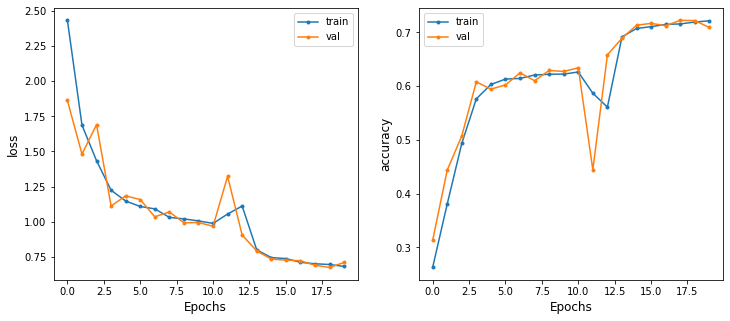

In [17]:
# 4. Trace
plot_trace(history)

In [18]:
# 5. Direct Evaluation

my_model.evaluate(X_val, Y_val)

Evaluating Model:  default
313/313 [==============================] - 0s 594us/step - loss: 0.7100 - accuracy: 0.7092


[0.7100400924682617, 0.7092000246047974]

In [19]:
# 6. Make Prediction 
Y_val_pred = my_model.predict(X_val)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.69      0.85      0.76      1000
           1       0.95      0.96      0.96      1000
           2       0.00      0.00      0.00      1000
           3       0.80      0.86      0.83      1000
           4       0.35      0.92      0.51      1000
           5       0.84      0.89      0.87      1000
           6       0.38      0.04      0.07      1000
           7       0.79      0.94      0.85      1000
           8       0.95      0.92      0.93      1000
           9       0.95      0.71      0.82      1000

    accuracy                           0.71     10000
   macro avg       0.67      0.71      0.66     10000
weighted avg       0.67      0.71      0.66     10000



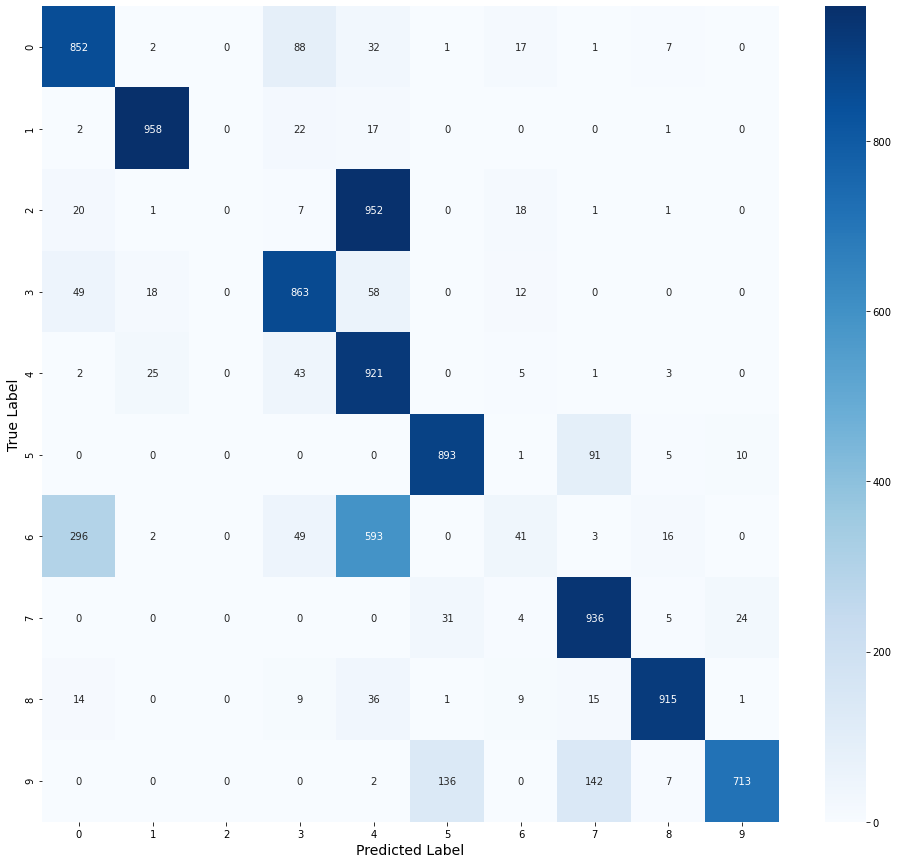

In [20]:
# 7. Confusion Matrix 

my_classification_report(Y_val, Y_val_pred)

## 1.2 Conclusion & Next Steps

- At this point, we can notice that with the default parameters our performance quite acceptable if not the best. We have been successful in building, training and predicting using our keras model.

- Next, its time to tune these parameters one by one and see how they affect our performance.

- As we explore parameters, one-by-one, you will complete your code to support using remaining values for each parameter.

#  2. Exploratory Analysis (50 Pts)

In this section, we will perform a series of experiments, one-by-one analyzing the performance when we tweak a specific parameter. For that purpose, we define the following two helper functions. Please read through them.

In [21]:
from itcs4156.util.timer import Timer

In [22]:
def analyze_parameter_performance(parameter_name, parameter_values):
    """
    Function to analyze performance of your keras model by varying the value of the 
    give parameter, while keeping other parameters same.
    
    parameters
    ----------
    parameter_name     str
                       parameter to vary
                       
    parameter_values   list
                       values that the parameter will take.
    
    returns
    --------
    losses             list
                       output losses corresponding to parameter_values
    
    accuracys          list
                       model accuracys corresponding to parameter_values
    
    times              list
                       time taken in seconds to train a model with parameter_value  
    
    """
    global X_tr, Y_tr, X_val, Y_val
    
    accuracys = []
    losses = []
    times = []
    
    # Below are the default values all experiments will use.
    # We will only update the value for the given parameter_name,
    # while keeping others fixed. 
    
    # You might want to experiment with different set of default values,
    # for eg, epochs is something you may lower or increase depending upon 
    # your computer's computation capacity. But be cautious, keeping them
    # too low can give you misleading results.
    
    dense_layers = [20, 10]
    activation = 'relu'
    regularization = None
    batch_norm = False
    weight_init = 'glorot_uniform'
    batch_size = 32
    optimizer = 'Adam'
    learning_rate = 0.001
    epochs = 20
    
    
    for val in parameter_values:
        
        if parameter_name == 'dense_layers':
            dense_layers = val
        elif parameter_name == 'activation':
            activation = val
        elif parameter_name == 'regularization':
            regularization = val
        elif parameter_name == 'batch_norm':
            batch_norm = val
        elif parameter_name == 'weight_init':
            weight_init == val
        elif parameter_name == 'batch_size':
            batch_size = val
        elif parameter_name == 'optimizer':
            optimizer = val
        elif parameter_name == 'learning_rate':
            learning_rate = val
        elif parameter_name == 'epochs':
            epochs = val
        else:
            raise ValueError("Unknown parameter: ", parameter_name)
        
        
        param_val = '_'.join([str(x) for x in val]) if isinstance(val, list) else str(val)
        name = "{}_{}".format(parameter_name, param_val) 

        model = KerasModel(dense_layers, activation, regularization, batch_norm, weight_init, batch_size,
                           optimizer, learning_rate, epochs, name) 
                          
        
        timer = Timer()
        start = timer.start()
        history = model.train(X_tr, Y_tr, X_val, Y_val, verbose=0)
        stop = timer.stop()
        time_elapsed = round(timer.last_elapsed_time)
        times.append(time_elapsed)
        
        loss, acc = model.evaluate(X_val, Y_val)
        losses.append(loss)
        accuracys.append(acc)
        
    return losses, accuracys, times

In [23]:
def plot_parameter_performance(losses, accs, times, parameter_name, parameter_labels):
    """
        Plots loss,accuracy & training time vs parameter_value
    """
    x_labels = [str(label) for label in parameter_labels]
    fig, axs = plt.subplots(1,3, figsize=(20,5))
    measures = [losses, accs, times]
    markers = ['x', 'o', '*']
    colors = ['r', 'g', 'b']
    y_labels = ['Loss', 'Accuracy', 'Time (s)']
    
    for i in range(3):
        axs[i].plot(measures[i], label = 'val', marker = markers[i], color=colors[i])
        axs[i].set_xticks(list(range(len(x_labels))))
        axs[i].set_xticklabels(x_labels)
        axs[i].set_xlabel(parameter_name, fontsize=12)
        axs[i].set_ylabel(y_labels[i], fontsize=12)
        axs[i].legend()

## 2.1 Network Architecture Search

In this section, we want to answer the question of how our network should look like? i.e, : 
 - How many layers should it have?
 - The number of units in each layer?
 - What kind of activation function to use?
 - Regularization technique?
 - Wheather to use batch normalization or not?
 - How to initialize our weights in the network?
 
We haven't gone into the details of how to select these parameters in this course (there are intutive ways to select them and there are theoritical proofs to support how one of them is better than other) . 
Most of the times people go with popular parameters that are already known to work well for a specific type of problem. For eg: the ones we used as defaults are very commonly used parameters and are a defaults for most libraries.

Another way is to do a grid search and evaluate the performance of each parameter and pick the best one.
This kind of approach is only feasible when we have a very small dataset that could finish training in seconds, as the number of combinations of the available hyperparameters can grow huge.

With our fashion-mnist dataset, we are going to take a middle approach. We will keep all other parameters fixed and vary just one of them one-by-one.


In [24]:
# Just an heads up: the following exepriments will get a little computationally expensive and time consuming 
# to evaluate but should be easy to implement and get credit for.

In [25]:
from itcs4156.assignments.DeepLearning.KerasModel import KerasModel

### 2.1.1 Depth of the Network (5 Pts)

In this section, we will ask the question "How many layers do I need in the network" a.k.a depth. 
Keeping the breadth of the network same, we add more layers to the network, we will train and evaluate different models and analyze their performance.

#### === TODO - 2 ===
Complete your code in KerasModel.py to support taking **dense_layers** parameter with different values.

In [26]:
layers_list = []

for i in range(1, 6):
    x = [10] * i
    #x = ','.join([str(i) for i in x])
    print("Depth {:2d}: {}".format(i, x))
    layers_list.append(x)

Depth  1: [10]
Depth  2: [10, 10]
Depth  3: [10, 10, 10]
Depth  4: [10, 10, 10, 10]
Depth  5: [10, 10, 10, 10, 10]


In [27]:
losses, accuracys, times = analyze_parameter_performance(parameter_name='dense_layers', parameter_values=layers_list)

Training Model:  dense_layers_10
Elapsed time: 20.4266 seconds
Evaluating Model:  dense_layers_10
313/313 [==============================] - 0s 597us/step - loss: 2.1262 - accuracy: 0.1936
Training Model:  dense_layers_10_10
Elapsed time: 21.2274 seconds
Evaluating Model:  dense_layers_10_10
313/313 [==============================] - 0s 554us/step - loss: 1.4603 - accuracy: 0.4722
Training Model:  dense_layers_10_10_10
Elapsed time: 22.6926 seconds
Evaluating Model:  dense_layers_10_10_10
313/313 [==============================] - 0s 559us/step - loss: 0.9493 - accuracy: 0.6072
Training Model:  dense_layers_10_10_10_10
Elapsed time: 23.5217 seconds
Evaluating Model:  dense_layers_10_10_10_10
313/313 [==============================] - 0s 581us/step - loss: 0.7330 - accuracy: 0.7458
Training Model:  dense_layers_10_10_10_10_10
Elapsed time: 23.2556 seconds
Evaluating Model:  dense_layers_10_10_10_10_10
313/313 [==============================] - 0s 620us/step - loss: 2.3026 - accuracy: 0.

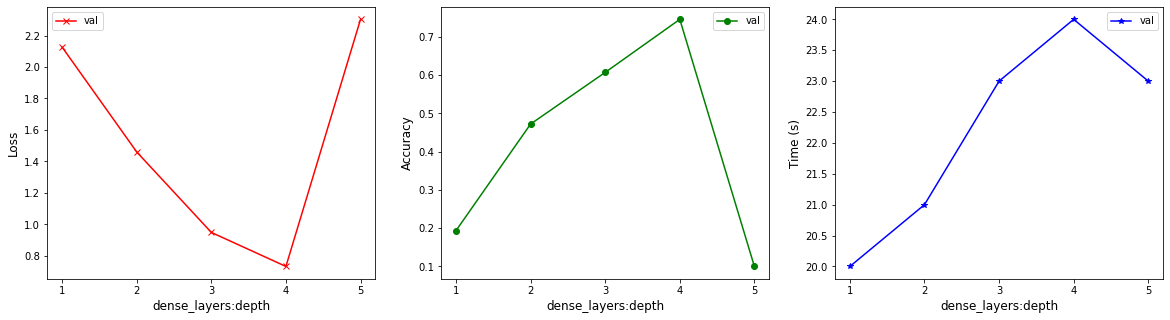

In [28]:
plot_parameter_performance(losses, accuracys, times, 'dense_layers:depth',  range(1,6))

### 2.1.2 Width of the Network (5 Pts)

Keeping the depth same, what happens when we increase the number of neural units in the dense layers? 
Train different models with varying units are report the performance.



In [29]:
layers_list = []

for i in range(1, 6):
    dense_layers = [i*10 ,10]
    print("Model {:2d}: {}".format(i, dense_layers))
    layers_list.append(dense_layers)

Model  1: [10, 10]
Model  2: [20, 10]
Model  3: [30, 10]
Model  4: [40, 10]
Model  5: [50, 10]


In [30]:
losses, accuracys, times = analyze_parameter_performance(parameter_name='dense_layers', parameter_values=layers_list)

Training Model:  dense_layers_10_10
Elapsed time: 21.2354 seconds
Evaluating Model:  dense_layers_10_10
313/313 [==============================] - 0s 549us/step - loss: 0.9841 - accuracy: 0.6421
Training Model:  dense_layers_20_10
Elapsed time: 22.3836 seconds
Evaluating Model:  dense_layers_20_10
313/313 [==============================] - 0s 567us/step - loss: 1.7161 - accuracy: 0.3767
Training Model:  dense_layers_30_10
Elapsed time: 23.6216 seconds
Evaluating Model:  dense_layers_30_10
313/313 [==============================] - 0s 567us/step - loss: 0.6792 - accuracy: 0.7806
Training Model:  dense_layers_40_10
Elapsed time: 22.6605 seconds
Evaluating Model:  dense_layers_40_10
313/313 [==============================] - 0s 576us/step - loss: 1.9740 - accuracy: 0.2560
Training Model:  dense_layers_50_10
Elapsed time: 25.4940 seconds
Evaluating Model:  dense_layers_50_10
313/313 [==============================] - 0s 662us/step - loss: 1.7427 - accuracy: 0.3594


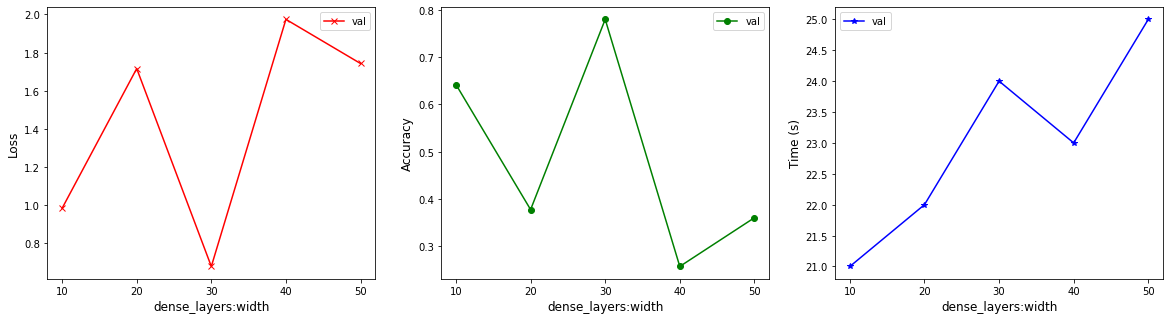

In [31]:
plot_parameter_performance(losses, accuracys, times, 'dense_layers:width', range(10,60,10))

### 2.1.3 Depth & Width (5 Pts)

In [32]:
layers_list = [] 

for i in range(1, 6):
    dense_layers = [ x * 10 for x in list(range(1,i+1))]
    dense_layers.reverse()
    print("Model {:2d}: {}".format(i, dense_layers))
    layers_list.append(dense_layers)

Model  1: [10]
Model  2: [20, 10]
Model  3: [30, 20, 10]
Model  4: [40, 30, 20, 10]
Model  5: [50, 40, 30, 20, 10]


In [33]:
losses, accuracys, times = analyze_parameter_performance(parameter_name='dense_layers', parameter_values=layers_list)

Training Model:  dense_layers_10
Elapsed time: 20.6644 seconds
Evaluating Model:  dense_layers_10
313/313 [==============================] - 0s 555us/step - loss: 2.1042 - accuracy: 0.1922
Training Model:  dense_layers_20_10
Elapsed time: 21.7953 seconds
Evaluating Model:  dense_layers_20_10
313/313 [==============================] - 0s 585us/step - loss: 1.6459 - accuracy: 0.3799
Training Model:  dense_layers_30_20_10
Elapsed time: 23.2349 seconds
Evaluating Model:  dense_layers_30_20_10
313/313 [==============================] - 0s 587us/step - loss: 0.5799 - accuracy: 0.7705
Training Model:  dense_layers_40_30_20_10
Elapsed time: 25.7878 seconds
Evaluating Model:  dense_layers_40_30_20_10
313/313 [==============================] - 0s 613us/step - loss: 1.4629 - accuracy: 0.4736
Training Model:  dense_layers_50_40_30_20_10
Elapsed time: 29.5855 seconds
Evaluating Model:  dense_layers_50_40_30_20_10
313/313 [==============================] - 0s 665us/step - loss: 0.3884 - accuracy: 0.

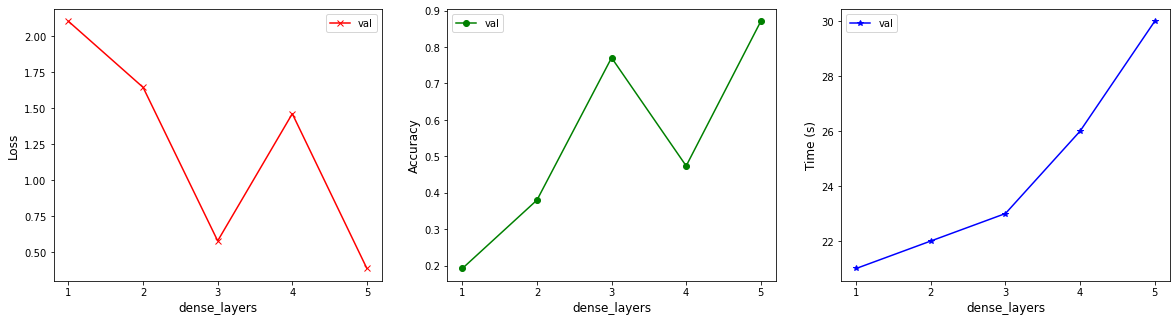

In [34]:
plot_parameter_performance(losses, accuracys, times, 'dense_layers', range(1,6))

### 2.1.4 Activation Functions (5 Pts)

Experiment with different activation functions and report the performance.

#### === TODO - 3  ===
Complete your code in KerasModel.py to support taking **activation** parameter with different values.


In [35]:
activations =['linear', 'relu', 'sigmoid', 'tanh', 'softplus', 'elu', 'selu', 'swish']

In [36]:
losses, accuracys, times = analyze_parameter_performance(parameter_name='activation', parameter_values=activations)

Training Model:  activation_linear
Elapsed time: 21.8774 seconds
Evaluating Model:  activation_linear
313/313 [==============================] - 0s 549us/step - loss: 0.5930 - accuracy: 0.8229
Training Model:  activation_relu
Elapsed time: 21.6204 seconds
Evaluating Model:  activation_relu
313/313 [==============================] - 0s 572us/step - loss: 1.1445 - accuracy: 0.6011
Training Model:  activation_sigmoid
Elapsed time: 22.8126 seconds
Evaluating Model:  activation_sigmoid
313/313 [==============================] - 0s 627us/step - loss: 1.7145 - accuracy: 0.3631
Training Model:  activation_tanh
Elapsed time: 22.7214 seconds
Evaluating Model:  activation_tanh
313/313 [==============================] - 0s 577us/step - loss: 1.3156 - accuracy: 0.4722
Training Model:  activation_softplus
Elapsed time: 23.3269 seconds
Evaluating Model:  activation_softplus
313/313 [==============================] - 0s 604us/step - loss: 0.8592 - accuracy: 0.6287
Training Model:  activation_elu
Elaps

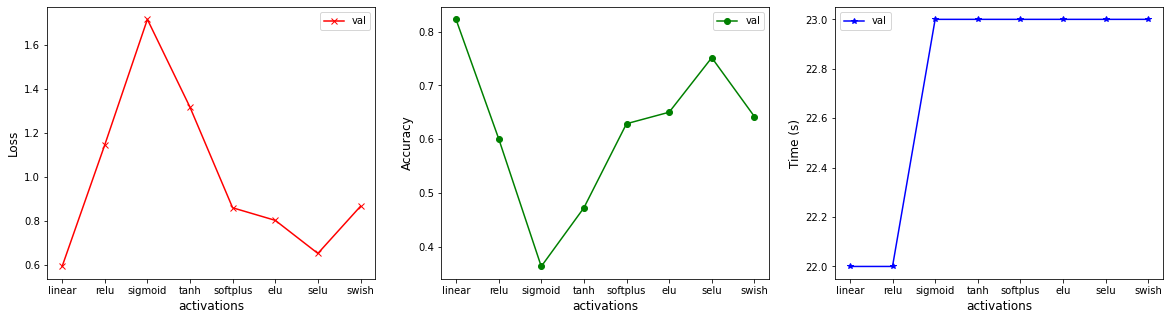

In [37]:
plot_parameter_performance(losses, accuracys, times, 'activations', activations)

### 2.1.5 Regularization (5 Pts)

Remember how we used $L2$ regularization to penalize larger weights of in Polynomial Regression?
Lets experiment with different regularization techniques to see what effect they have on our model performance.

#### === TODO - 4  ===
Complete your code in KerasModel.py to support taking **regularization** parameter with different values.


In [38]:
regularizations = ['l1', 'l2', 'l1_l2', 'dropout']

In [39]:
losses, accuracys, times = analyze_parameter_performance(parameter_name='regularization', parameter_values=regularizations)

Training Model:  regularization_l1
Elapsed time: 22.8377 seconds
Evaluating Model:  regularization_l1
313/313 [==============================] - 0s 560us/step - loss: 1.0787 - accuracy: 0.7001
Training Model:  regularization_l2
Elapsed time: 24.1612 seconds
Evaluating Model:  regularization_l2
313/313 [==============================] - 0s 603us/step - loss: 1.6951 - accuracy: 0.4051
Training Model:  regularization_l1_l2
Elapsed time: 24.9692 seconds
Evaluating Model:  regularization_l1_l2
313/313 [==============================] - 0s 681us/step - loss: 1.0860 - accuracy: 0.7285
Training Model:  regularization_dropout
Elapsed time: 25.6783 seconds
Evaluating Model:  regularization_dropout
313/313 [==============================] - 0s 577us/step - loss: 0.5497 - accuracy: 0.8235


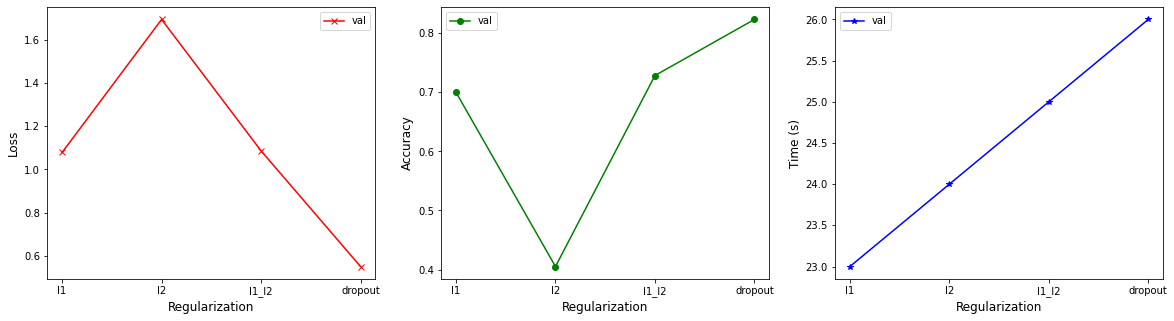

In [40]:
plot_parameter_performance(losses, accuracys, times, 'Regularization', regularizations)

### 2.1.6 Batch Normalization (5 Pts)

How does the presence of batch normalization layer affect the performance of our network?

#### === TODO - 5  ===
Complete your code in KerasModel.py to support taking **batch_norm** parameter with different values.


In [41]:
batch_norm = [True, False]

In [42]:
losses, accuracys, times = analyze_parameter_performance(parameter_name='batch_norm', parameter_values=batch_norm)

Training Model:  batch_norm_True
Elapsed time: 31.1617 seconds
Evaluating Model:  batch_norm_True
313/313 [==============================] - 0s 703us/step - loss: 0.3770 - accuracy: 0.8690
Training Model:  batch_norm_False
Elapsed time: 23.7732 seconds
Evaluating Model:  batch_norm_False
313/313 [==============================] - 0s 576us/step - loss: 1.6771 - accuracy: 0.3827


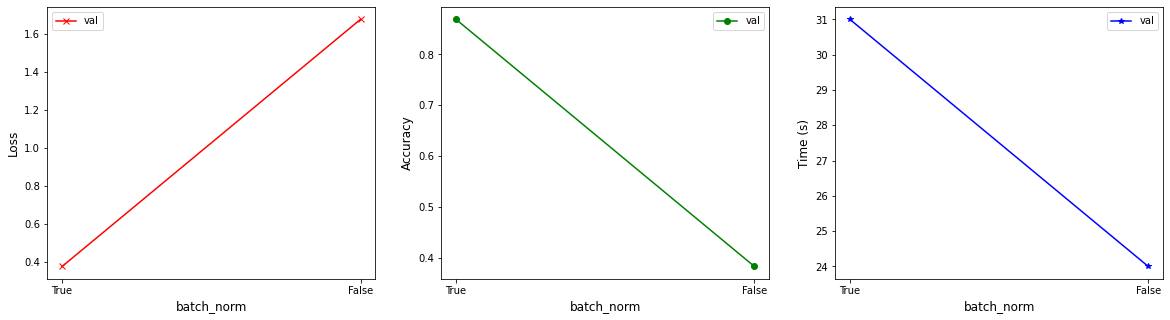

In [43]:
plot_parameter_performance(losses, accuracys, times, 'batch_norm', batch_norm)

### 2.1.7 Weight Initialization (5 Pts)
Does it matter how we initialize the weights of the network?

#### === TODO -  6 ===
Complete your code in KerasModel.py to support taking **weight_init** parameter with different values.



In [44]:
weight_init = ['glorot_normal', 'glorot_uniform', 'he_normal', 
               'he_uniform', 'random_nomal', 'random_uniform', 'ones',]

weight_labels = ['gl_norm', 'gl_uni', 'he_norm', 'he_uni', 'rd_norm', 'rd_uni', 'ones']

In [45]:
losses, accuracys, times = analyze_parameter_performance(parameter_name='weight_init', parameter_values=weight_init)

Training Model:  weight_init_glorot_normal
Elapsed time: 22.2373 seconds
Evaluating Model:  weight_init_glorot_normal
313/313 [==============================] - 0s 601us/step - loss: 1.2866 - accuracy: 0.5612
Training Model:  weight_init_glorot_uniform
Elapsed time: 22.0220 seconds
Evaluating Model:  weight_init_glorot_uniform
313/313 [==============================] - 0s 571us/step - loss: 1.1611 - accuracy: 0.5542
Training Model:  weight_init_he_normal
Elapsed time: 22.9112 seconds
Evaluating Model:  weight_init_he_normal
313/313 [==============================] - 0s 605us/step - loss: 2.3026 - accuracy: 0.1000
Training Model:  weight_init_he_uniform
Elapsed time: 24.4674 seconds
Evaluating Model:  weight_init_he_uniform
313/313 [==============================] - 0s 585us/step - loss: 1.5113 - accuracy: 0.4772
Training Model:  weight_init_random_nomal
Elapsed time: 22.4581 seconds
Evaluating Model:  weight_init_random_nomal
313/313 [==============================] - 0s 582us/step - l

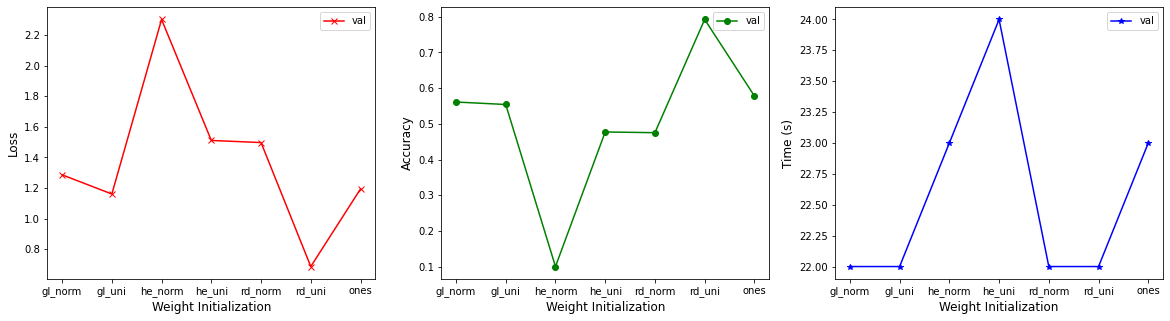

In [46]:
plot_parameter_performance(losses, accuracys, times, 'Weight Initialization', weight_labels)

## 2.2 Training Hyperparameter Search

Once we fix our network architecture, we need to figure our how we are going to train it. After deciding on the loss function, we decide on batch size of the data, the optimizer which updates our weights and the learning rate.


### 2.2.1 Batch Size (5 Pts)

We are providing the batch size in our model.fit() call by default. So no more work is required here as its already taken care of.


In [47]:
batch_sizes = [8,16,32,64,128]

In [48]:
losses, accuracys, times = analyze_parameter_performance('batch_size', batch_sizes)

Training Model:  batch_size_8
Elapsed time: 75.8911 seconds
Evaluating Model:  batch_size_8
313/313 [==============================] - 0s 957us/step - loss: 0.6442 - accuracy: 0.7695
Training Model:  batch_size_16
Elapsed time: 38.4002 seconds
Evaluating Model:  batch_size_16
313/313 [==============================] - 0s 898us/step - loss: 1.4603 - accuracy: 0.4775
Training Model:  batch_size_32
Elapsed time: 22.9705 seconds
Evaluating Model:  batch_size_32
313/313 [==============================] - 0s 662us/step - loss: 0.9358 - accuracy: 0.6970
Training Model:  batch_size_64
Elapsed time: 14.5093 seconds
Evaluating Model:  batch_size_64
313/313 [==============================] - 0s 562us/step - loss: 0.6728 - accuracy: 0.7325
Training Model:  batch_size_128
Elapsed time: 8.4548 seconds
Evaluating Model:  batch_size_128
313/313 [==============================] - 0s 587us/step - loss: 0.9936 - accuracy: 0.7123


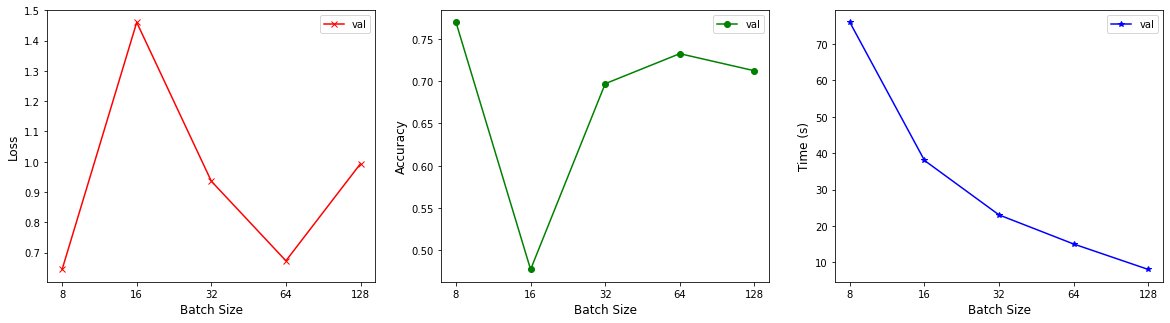

In [49]:
plot_parameter_performance(losses, accuracys, times, 'Batch Size', batch_sizes)

### 2.2.2 Learning Rate (5 Pts)

#### === TODO - 7  ===
Complete your code in KerasModel.py to support taking **learning_rate** parameter with different values.


In [50]:
lr_rates = [0.001, 0.003, 0.009, 0.01, 0.03, 0.09, 0.1, 0.3, 0.9]

In [51]:
losses, accuracys, times  = analyze_parameter_performance('learning_rate', lr_rates)

Training Model:  learning_rate_0.001
Elapsed time: 24.7594 seconds
Evaluating Model:  learning_rate_0.001
313/313 [==============================] - 0s 670us/step - loss: 1.3794 - accuracy: 0.5106
Training Model:  learning_rate_0.003
Elapsed time: 24.1628 seconds
Evaluating Model:  learning_rate_0.003
313/313 [==============================] - 0s 604us/step - loss: 2.3026 - accuracy: 0.1000
Training Model:  learning_rate_0.009
Elapsed time: 22.4528 seconds
Evaluating Model:  learning_rate_0.009
313/313 [==============================] - 0s 575us/step - loss: 2.3026 - accuracy: 0.1000
Training Model:  learning_rate_0.01
Elapsed time: 22.7556 seconds
Evaluating Model:  learning_rate_0.01
313/313 [==============================] - 0s 603us/step - loss: 2.3026 - accuracy: 0.1000
Training Model:  learning_rate_0.03
Elapsed time: 22.7417 seconds
Evaluating Model:  learning_rate_0.03
313/313 [==============================] - 0s 626us/step - loss: 2.3026 - accuracy: 0.1000
Training Model:  le

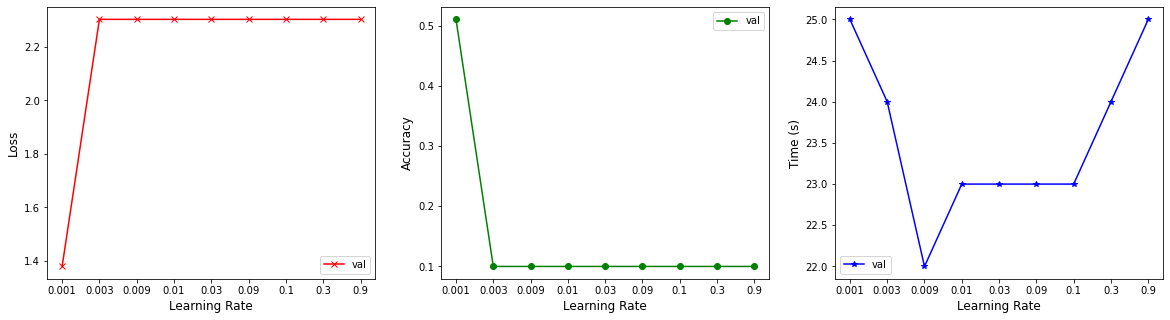

In [52]:
plot_parameter_performance(losses, accuracys, times, 'Learning Rate', lr_rates)

### 2.2.3 Optimizer (5 Pts)

#### === TODO - 8  ===
Complete your code in KerasModel.py to support taking **optimizer** parameter with different values.


In [53]:
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Ftrl', 'Nadam', 'RMSprop', 'SGD']

In [54]:
losses, accuracys, times = analyze_parameter_performance('optimizer', optimizers)

Training Model:  optimizer_Adadelta
Elapsed time: 23.6486 seconds
Evaluating Model:  optimizer_Adadelta
313/313 [==============================] - 0s 616us/step - loss: 2.7282 - accuracy: 0.2004
Training Model:  optimizer_Adagrad
Elapsed time: 19.4632 seconds
Evaluating Model:  optimizer_Adagrad
313/313 [==============================] - 0s 601us/step - loss: 2.0318 - accuracy: 0.2390
Training Model:  optimizer_Adam
Elapsed time: 22.3365 seconds
Evaluating Model:  optimizer_Adam
313/313 [==============================] - 0s 581us/step - loss: 1.1954 - accuracy: 0.5465
Training Model:  optimizer_Adamax
Elapsed time: 19.7230 seconds
Evaluating Model:  optimizer_Adamax
313/313 [==============================] - 0s 560us/step - loss: 1.1267 - accuracy: 0.6155
Training Model:  optimizer_Ftrl
Elapsed time: 21.4483 seconds
Evaluating Model:  optimizer_Ftrl
313/313 [==============================] - 0s 544us/step - loss: 2.1670 - accuracy: 0.1732
Training Model:  optimizer_Nadam
Elapsed time: 

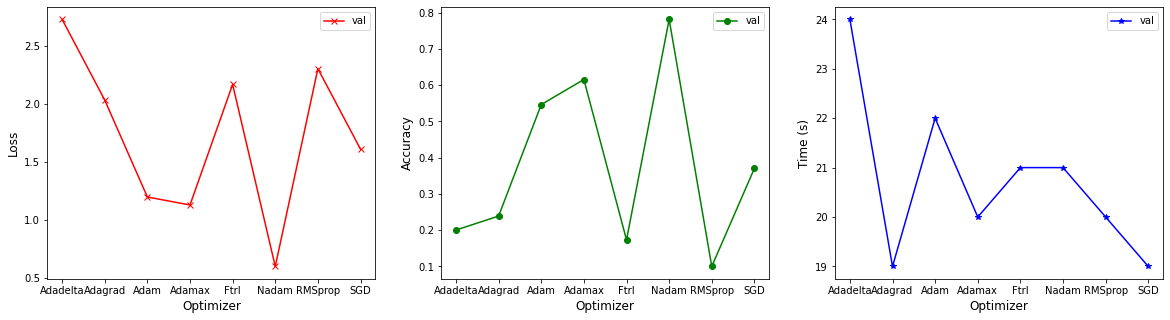

In [55]:
plot_parameter_performance(losses, accuracys, times, 'Optimizer', optimizers)

# Choose Your Best Parameters

At this point, we have experimented with default parameters, and we have also measured the effect of different values of parameters on accuracy. That means we have some understanding of what are the good parameters and how to improve our accuracy.


### ==== TODO - 9 ====

Open the **train.py** given with this assignment and set the parameters values you think are going to give you best performance based on our analysis in the above section. Next, run the evaluation script below to see how they perform.
When you are ready, make a submission on Autolab.

In [ ]:
from itcs4156.assignments.DeepLearning.evaluate import eval
eval()

Setting Random Seed:  25
Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\FMNIST\train.zip

Unzipping: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\FMNIST\train.zip

Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\FMNIST\val.zip

Unzipping: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\FMNIST\val.zip

Loading dataset..
Done!

1. Initializing model with parameters: 
 dense_layers: [200, 100, 50, 40, 30, 20, 10], activation: relu, regularization: l2, 
            batch_norm: True, weight_init: glorot_uniform, batch_size: 32,
            optimizer: Adam, learning_rate: 0.0001, epochs: 30


2. Building model:
Model: "Test"
_________________________________________________________________
Layer (type)               

# Grading 


The final grading will be done on **TEST** dataset when you submit this assignment on **Autolab**. 

Points | Description
--|--------:
50 | KerasModel (Accuracy)
50 | Exploratory Analysis
(**Extra**) 10 | $\frac{(N - R + 1)}{N} \times 10$   

The last 10 points will be calculated based on your rank (R) among all students (N). The rank will be computed based on your scores and accuracy. It will be visible to you (and anonymous to others) in leaderboard on Autolab as you make submissions.  

## Scoring scheme for KerasModel based on Accuracy

In [57]:
from itcs4156.assignments.DeepLearning.evaluate import score_classification
print(inspect.getsource(score_classification))

def score_classification(acc, max_score):
    if acc >= 0.9:
        score_percent = 100
    else:
        score_percent = (acc / 0.9) * 100 
        if score_percent < 40:
            score_percent = 40
    score = max_score * score_percent / 100.0 
    return score



# Submission


```
| - itcs4156
    | - assignments
        | - DeepLearning   <----------- Zip this folder and submit on AutoLab
            | - train.py
            | - KerasModel.py
            | - evaluate.py
            | - __init__.py
    | - notebooks
        | - 4 - Deep Learning.ipynb <----- Upload this file on Canvas
```